<div class="alert alert-block alert-info">

<b>Thank you for contributing to TeachOpenCADD!</b>

</div>

<div class="alert alert-block alert-info">

<b>Set up your PR</b>: Please check out our <a href="https://github.com/volkamerlab/teachopencadd/issues/41">issue</a> on how to set up a PR for new talktorials, including standard checks and TODOs.

</div>

# T037 · An introduction to $\text{E}(3)$-equivariant graph neural networks

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Joschka Groß, 2022, Chair for Modelling and Simulation, Saarland University,

## Aim of this talktorial

This talktorial is supposed to serve as an introduction to molecular machine learning on point clouds, i.e., molecular graphs that are embedded into euclidean space (see **Talktorial 033**). You will learn why euclidean equivariance and invariance are important properties of neural networks (NNs) that take point clouds as input and learn how to implement and train such NNs. In addition to discussing them in theory, this notebook also aims to demonstrate the shortcomings of plain graph neural networks (GNNs) when working with point clouds practically.

### Contents in *Theory*

* Why 3D coordinates?
* Representing molecules as point clouds
* Equivariance and invariance in euclidean space and why we care
* How to construct $\text{E}(n)$-invariant and equivariant models
* The QM9 dataset

### Contents in *Practical*

* Visualization of point clouds
* Set up and inspect the QM9 dataset
  * Preprocessing
  * Atomic number distribution and point cloud size
  * Data split, distribution of regression target electronic spatial extent
  * Visualizing atom coordinates and inspecting their relation to electronic spatial extent
* Model implementation
  * Plain "naive euclidean" GNN
  * Demo: Plain GNNs are not E(3)-invariant
  * EGNN model
  * Demo: Our EGNN is E(3)-invariant
* Training and evaluation
  * Setup
  * Training the EGNN
  * Training the plain GNN
  * Comparative evaluation

<div class="alert alert-block alert-info">

<b>Sync TOC with section titles</b>: These points should refer to the headlines of your <i>Practical</i> section.

</div>

### References

* **$\text{E}(n)$ Equivariant Graph Neural Networks**: [<i>International conference on machine learning</i> (2021), <b>139<b>, 99323-9332](https://proceedings.mlr.press/v139/satorras21a.html) $[1]$
* 

*We suggest the following citation style:*
* Keyword describing resource: <i>Journal</i> (year), <b>volume</b>, pages (link to resource) 


## Theory

<div class="alert alert-block alert-info">
    
<b>Figures</b>: Place images in the <code>images/</code> folder and include them using Markdown <code>![Figure title](images/some_figure.jpg)</code>. Add a figure caption in the format shown in the example.

</div>

### Why 3D coordinates?

* Some properties are more easily derived when 3D coordinates are known.
* Sometimes the task is to predict properties that are directly linked to euclidean space, e.g. atom positions or forces that apply to atoms.
* In principle, we do not lose any structural information. Covalent bonds can still be inferred from atom types and positions, because they
can be attributed to overlapping atomic orbitals. One could still include structural information s.t. the model does not have to learn this
information itself

For instance, one application that may require the use of 3D coordinates is protein-ligand docking (see **Talktorial 015**). Work from 2022 by (TODO cite) uses E(3) equivariant graph neural networks as the backbone for a generative model that learns to predict potential ligand docking positions (3D coordinates for the ligand atoms) when additionally given protein structures with 3D information as input.

### Representing molecules as point clouds, mathematically
Here, we will focus on atoms and their 3D positions and ignore structural (bond) information. Our mathematical representations of molecules are thus point clouds (also see **Talktorial 33**), i.e., tuples $(X, Z)$ where $Z \in \mathbb{R}^{m \times d}$ is a matrix of $d$-dimensional atom features and $X \in \mathbb{R}^{m \times 3}$ captures the atom 3D-xyz coordinates. We will assume that the coordinates are derived from some *conformer* of the molecule.

### Equivariance and invariance in euclidean space and why we care

In **Talktorial 034** you were taught why equi- and/or invariance w.r.t. to node permutations is a desirable model property when representing molecules by their molecular graphs. When embedding molecular graphs into euclidean space, we now also need to worry about euclidean symmetry groups. These are groups of transformations $g: \mathbb{R}^n \to \mathbb{R}^n$ that preserve distance, i.e., translations, rotations, reflections, or combinations thereof. For the euclidean space $\mathbb{R}^n$ with $n$ spatial dimensions, one typically distinguishes between
* the euclidean group $\text{E}(n)$, which consists of *all* distance-preserving transformations, and
* the special euclidean group $\text{SE}(n)$, which consists only of translations and rotations.
  
Say $\theta$ is a model that learns atom embeddings $H = \theta(X, Z) \in \mathbb{R}^{m \times q}$ where $q$ is the number of embedding dimensions. We call $\theta$ $\text{E}(n)$-*invariant*, if for all $g \in \text{E}(n)$
$$
\theta(X, g(Z)) = \theta(X, Z),
$$
where $g$ is applied row-wise to Z.

If we consider a model that makes predictions about objects which are coupled to the euclidean space $X' = \theta(X, Z) \in \mathbb{R}^{m \times n}$ (e.g. atom positions with $n=3$), we can define $\text{E}(n)$-*equivariance* as
$$
\theta(X, g(Z)) = g(\theta(X, Z)),
$$
for all $g \in \text{E}(n)$ applied in row-wise fashion. Note that this definition can easily be extended to arbitrary euclidean features (velocities, electromagnetic forces, ...).

So, why do we care about these properties?

Let's assume our goal was to train a model that predicts the docking position of a ligand when given a fixed protein structure, also with 3D coordinates. Would you trust a model that predicted different relative positions for the ligand atoms when the protein was simply rotated by 180 degrees along the z-axis? If your answer is no, then you should consider using a model that is at least $\text{SE}(3)$-equivariant.
In addition to being a "natural" choice given such considerations, euclidean equivariance empirically also increases the sample complexity (efficiency) of training and improves the model's ability to generalize to unseen data (TODO cite?).

### How to construct $\text{E}(n)$-invariant and equivariant models

Constructing such models is simple if you know that all $g \in \text{E}(3)$ are *distance-preserving*. We will not give a fully-fledged proof (if you are interested see e.g. Hoogeboom et. al.), but it should not come as a great surprise that a model which *only considers relative distances* for its internal computations is guaranteed to be $E(3)$ invariant. We can thus define a *message passing network* $\theta(Z, X)$ with $l=1,\ldots,L$ layers where

\begin{align*}
    h_{i}^0 &= \psi_0(Z_i) && (1)\\
    d_{ij} &= ||X_i - X_j||^2 && (2) \\
    m_{ij}^{l} &= \phi_{l}(h_i^l, h_j^l, d_{ij})  ~~\text{for}~l=0,\ldots,L-1 && (3)\\
    h_{i}^{l+1} &= \psi_l(h_{i}^l, \sum_{j \neq i} m_{ij}^l) ~~\text{for}~l=0,\ldots,L-1 && (4)
\end{align*}

and $\psi_0$ computes the inital node embeddings, the $\phi_l$ MLPs $\text{}^1$ construct messages and $\psi_l$ MLPs take care of combining previous embeddings and aggregated messages into new embeddings. The final node embeddings $H = (h_1^L \ldots h_n^L)^t$ computed by this scheme are $E(3)$-invariant.

In the practical part we will only predict properties that are not directly linked to the euclidean space, so this kind of network suffices for our purposes. If your goal is to predict e.g. atom positions, you will need to define additional, slightly more sophisticated transformations to ensure that they are $E(3)$-equivariant, but they follow the same principle of only using distances in their computations. If you want to read up on this you can take a look at
* CITE EGNN
* CITE SE(3) Transformer
* CITE TORCH-MD Net equivariant transformer

\
\
$~^1$ multi-layer perceptrons (MLPS) are stacks of multiple fully connected layers with non-linear activation functions (also see **Talktorial 022**)

### The QM9 dataset

The QM9 dataset is part of MoleculeNet and consists of ~130k small, organic molecules with up to 9 heavy atoms. It also includes targets for various geometric, energetic, electronic and thermodynamic properties. Crucially, it also includes 3D coordinates, which makes it suitable for this talktorial.

## Practical

For the practical part we will be working with a version of QM9 that is already included in PyTorch Geometric, as implementing the dataset from scratch would go beyond the scope of this talktorial. We will just inspect the data and briefly discuss how point clouds are represented as tensors. Then we will demonstrate how one could use plain GNNs to work with point clouds and why this approach would yield models that are not $\text{E}(3)$ invariant/equivariant. Finally, you will learn how to implement, train and evaluate equivariant GNNs.

In [1]:
import math
import operator
from itertools import chain, product
from functools import partial
from pathlib import Path
from typing import Any, Optional, Callable, Tuple, Dict, Sequence, NamedTuple

import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
from torch import Tensor, LongTensor

import torch_geometric
from torch_geometric.transforms import BaseTransform, Compose
from torch_geometric.datasets import QM9
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.nn.aggr import SumAggregation
import torch_geometric.nn as geom_nn

from torch_scatter import scatter

import matplotlib as mpl
import matplotlib.pyplot as plt


In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Visualization of point clouds
The following auxiliary function `plot_point_cloud_3d` will see heavy use later on for the visualization of model input and model outputs.
Note that in order to visualize molecules rather than their representations used for machine learning, it would be better to use e.g. `RDKit` or `NGLview`.

/var/folders/8r/pydj0px5315ckmngntlp2m3c0000gn/T/ipykernel_61111/3483612189.py:77: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


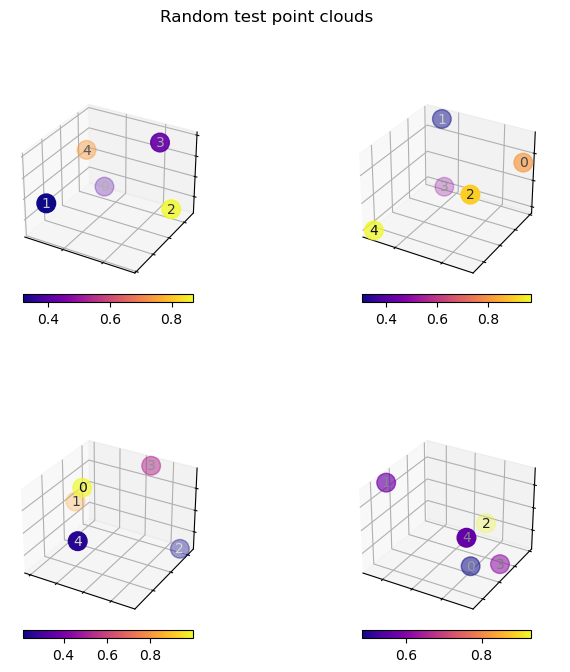

In [4]:
# auxiliary function for choosing label colors
# that improve visibility wrt to background color brightness
def to_perceived_brightness(rgb: np.ndarray) -> np.ndarray:
    """No"""
    r, g, b = rgb
    return 0.1 * r + 0.8 * g + 0.1

def plot_point_cloud_3d(
    fig: mpl.figure.Figure,
    ax_pos: int,
    color: np.ndarray,
    pos: np.ndarray,
    cmap: str = "plasma",
    point_size: float = 180.0,
    label_axes: bool = False,
    annotate_points: bool = True,
    remove_axes_ticks: bool = True,
    cbar_label: str = "",
) -> mpl.axis.Axis:
    """Visualize colored 3D point clouds.

    Parameters
    ----------
    fig : mpl.figure.Figure
        The figure ro which a new axis object is added for plotting
    ax_pos : int
        Three-digit integer specifying axis layout and position
        (see docs for `mpl.figure.Figure.add_subplot`)
    color : np.ndarray
        The point colors as a float array of shape `(N,)`
    pos : np.ndarray
        The point xyz-coordinates as an array of shape ``
    cmap : str, optional
        String identifier for a matplotlib colormap.
        Is used to map the values in `color` to rgb colors.
        , by default "plasma"
    point_size : float, optional
        The size of plotted points, by default 180.0
    label_axes : bool, optional
        whether to label x,y and z axes by default False
    annotate_points : bool, optional
        whether to label points with their index, by default True
    cbar_label : str, optional
        label for the colorbar, by default ""

    Returns
    -------
    mpl.axis.Axis
        The new axis object for the 3D point cloud plot.
    """
    cmap = mpl.cm.get_cmap(cmap)
    ax = fig.add_subplot(ax_pos, projection="3d")
    x, y, z = pos
    if remove_axes_ticks:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    if label_axes:
        ax.set_xlabel("$x$ coordinate")
        ax.set_ylabel("$y$ coordinate")
        ax.set_zlabel("$z$ coordinate")
    sc = ax.scatter(x, y, z, c=color, cmap=cmap, s=point_size)
    plt.colorbar(sc, location="bottom", shrink=0.6, anchor=(0.5, 2), label=cbar_label)
    if annotate_points:
        _colors = sc.cmap(color)
        rgb = _colors[:, :3].transpose()
        brightness = to_perceived_brightness(rgb)
        for i, (xi, yi, zi, li) in enumerate(zip(x, y, z, brightness)):
            ax.text(
                xi, yi, zi, str(i), None, color=[1 - li] * 3, ha="center", va="center"
            )
    return ax


# testing
fig = plt.figure(figsize=(8, 8))

for ax_pos in [221, 222, 223, 224]:
    pos = np.random.rand(3, 5)
    color = np.random.rand(5)
    plot_point_cloud_3d(fig, ax_pos, color, pos)

fig.suptitle("Random test point clouds")
fig.tight_layout()


In [5]:
def plot_model_input(data: Data, fig: mpl.figure.Figure, ax_pos: int) -> mpl.axis.Axis:
    """
    Plots 3D point cloud model input represented by a torch geometric
    `Data` object. Use atomic numbers as colors.

    Parameters
    ----------
    data : Data
        the 3D point cloud. Must have atomic numbers `z` and 2D coordinates `pos`
        properties that are not `None`.
    """
    color, pos = data.z, data.pos
    color = color.flatten().detach().numpy()
    pos = pos.T.detach().numpy()
    return plot_point_cloud_3d(fig, ax_pos, color, pos, cbar_label="Atomic number")


def plot_model_embedding(
    data: Data, model: Callable[[Data], Tensor], fig: mpl.figure.Figure, ax_pos: int
) -> mpl.axis.Axis:
    """
    Same as `plot_model_input` but instead of node features as color,
    first apply a GNN model to obtain colors from node embeddings.

    Parameters
    ----------
    data : Data
        the model input. Must have 3D coordinates `pos`
        an atomic number `z` properties that are not `None`.
    model : Callable[[Data], Tensor]
        the model must take Data objects as input and return node embeddings
        as a Tensor output.
    """
    x = model(data)
    pos = data.pos
    color = x.flatten().detach().numpy()
    pos = pos.T.detach().numpy()
    return plot_point_cloud_3d(
        fig, ax_pos, color, pos, cbar_label="Atom embedding (1D)"
    )


### Set up and inspect the QM9 dataset

#### Preprocessing
For the sake of this tutorial we will restrict ourselves to small molecules with at most 8 heavy atoms. Due to our decision to ignore structural information and treat molecules as point clouds, where every atom interacts with every other atom, we also need to extend the torch geometric `Data` objects with additional adjacency information that represents a complete graph without self loops.

For performance reasons, both of these steps are performed *once* when pre-processing the raw data using the `pre_filter` and `pre_transform` keyword arguments of the dataset class.

In [6]:
def num_heavy_atoms(qm9_data: Data) -> int:
    """Count the number of heavy atoms in a torch geometric
    Data object.

    Parameters
    ----------
    qm9_data : Data
        A pytorch geometric qm9 data object representing a small molecule
         where atomic numbers are stored in a
    tensor-valued attribute `Data.z`

    Returns
    -------
    int
        The number of heavy atoms in the molecule.
    """
    # every atom with atomic number other than 1 is heavy
    # the torch geometric qm9 dataset stores
    # the atomic number in the first (zeroth)
    # node-feature channel
    return (qm9_data.z != 1).sum()


def complete_edge_index(n: int) -> LongTensor:
    """
    Constructs a complete edge index.
    
    NOTE: representing complete graphs
    with sparse edge tensors is arguably a bad idea
    due to performance reasons, but for this tutorial it'll do.

    Parameters
    ----------
    n : int
        the number of nodes in the graph.

    Returns
    -------
    LongTensor
        A pytorch `edge_index` representing a complete graph with n nodes,
        without self-loops. Shape (2, n).
    """
    # filter removes self loops
    edges = list(filter(lambda e: e[0] != e[1], product(range(n), range(n))))
    return torch.tensor(edges, dtype=torch.long).T


def add_complete_graph_edge_index(data: Data) -> Data:
    """
    On top of any edge information already there,
    add a second edge index that represents
    the complete graph corresponding to a  given
    torch geometric data object

    Parameters
    ----------
    data : Data
        The torch geometric data object.

    Returns
    -------
    Data
        The torch geometric `Data` object with a new    
        attribute `complete_edge_index` as described above.
    """
    data.complete_edge_index = complete_edge_index(data.num_nodes)
    return data


#
dataset = QM9(
    DATA,
    # filter out molecules with more than 8 heavy atoms
    pre_filter=lambda data: num_heavy_atoms(data) < 9,
    # implement point cloud adjacency as a complete graph
    pre_transform=add_complete_graph_edge_index,
)

print(
    f"Num. examples in QM9 restricted to molecules with at most 8 heavy atoms: {len(dataset)}"
)


Num. examples in QM9 restricted to molecules with at most 8 heavy atoms: 21800


NOTE: executing the above cell for the first time first downloads and then processes the raw data, which might take a while.

#### Atomic number distribution and point cloud size
Now that our dataset is set up, we can try to visualize our data and some of its properties. 
Let us first look at the distribution of node-level features (atomic numbers) and the point cloud size (number of atoms) aggregated over the entire dataset.

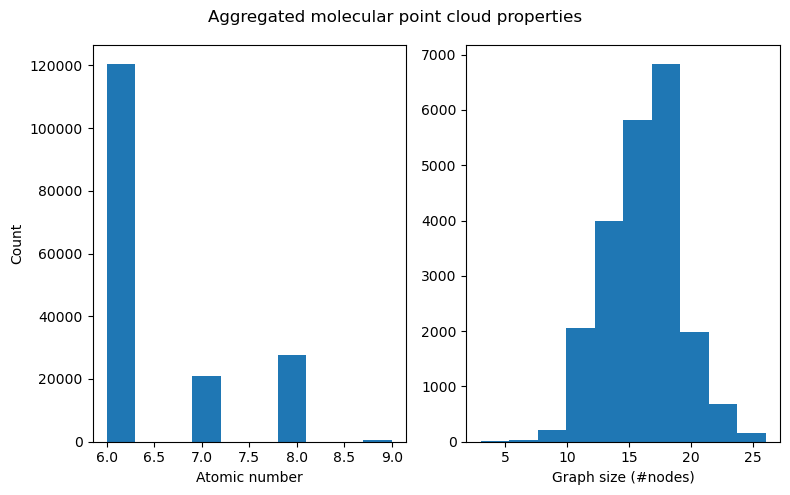

In [7]:
fig, (ax_atoms, ax_graph_size) = plt.subplots(1, 2, figsize=(8,5))

ax_atoms.hist(dataset.data.z[dataset.data.z != 1])
ax_atoms.set_xlabel("Atomic number")
ax_atoms.set_ylabel("Count")
num_nodes = [dataset[i].num_nodes for i in range(len(dataset))]
ax_graph_size.hist(num_nodes)
ax_graph_size.set_xlabel("Graph size (#nodes)")
fig.suptitle("Aggregated molecular point cloud properties")
fig.tight_layout()

We can see that while fluorine atoms (number 9) show up in the data, they are heavily underrepresented, which is not a nice property that is likely due to the fact that we shrunk the dataset. The number of atoms seems to be roughly normally distributed.

#### Data split, distribution of regression target electronic spatial extent
Next we will implement data splitting, choose a regression target and visualize the split w.r.t. to this target. 
Out of the 19 regression targets included in QM9, we'll focus on [electronic spatial extent](TODO), which, simply put, describes the volume of a molecule, so it should be a good fit for methods that use 3D information.
Let us now start with implementing a *data module* that takes care of train/val/test splits and of indexing the correct target.

In [8]:
class QM9DataModule:
    def __init__(
        self,
        train_ratio: float = 0.8,
        val_ratio: float = 0.1,
        test_ratio: float = 0.1,
        target_idx: int = 5,
        seed: float = 420,
    ) -> None:
        """Encapsulates everything related to the dataset

        Parameters
        ----------
        train_ratio : float, optional
            fraction of data used for training, by default 0.8
        val_ratio : float, optional
            fraction of data used for validation, by default 0.1
        test_ratio : float, optional
            fraction of data used for testing, by default 0.1
        target_idx : int, optional
            index of the target (see torch geometric docs), by default 5 (electronic spatial extent)
            (https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html?highlight=qm9#torch_geometric.datasets.QM9)
        seed : float, optional
            random seed for data split, by default 420
        """
        assert sum([train_ratio, val_ratio, test_ratio]) == 1
        self.target_idx = target_idx
        self.num_examples = len(self.dataset())
        rng = np.random.default_rng(seed)
        self.shuffled_index = rng.permutation(self.num_examples)
        self.train_split = self.shuffled_index[: int(self.num_examples * train_ratio)]
        self.val_split = self.shuffled_index[
            int(self.num_examples * train_ratio) : int(
                self.num_examples * (train_ratio + val_ratio)
            )
        ]
        self.test_split = self.shuffled_index[
            int(self.num_examples * (train_ratio + val_ratio)) : self.num_examples
        ]

    def dataset(self, transform=None) -> QM9:
        dataset = QM9(
            DATA,
            pre_filter=lambda data: num_heavy_atoms(data) < 9,
            pre_transform=add_complete_graph_edge_index,
        )
        dataset.data.y = dataset.data.y[:, self.target_idx].view(-1, 1)
        return dataset

    def loader(self, split, **loader_kwargs) -> DataLoader:
        dataset = self.dataset()[split]
        return DataLoader(dataset, **loader_kwargs)

    def train_loader(self, **loader_kwargs) -> DataLoader:
        return self.loader(self.train_split, shuffle=True, **loader_kwargs)

    def val_loader(self, **loader_kwargs) -> DataLoader:
        return self.loader(self.val_split, shuffle=False, **loader_kwargs)

    def test_loader(self, **loader_kwargs) -> DataLoader:
        return self.loader(self.test_split, shuffle=False, **loader_kwargs)


Now we can easily plot the target across the data split.

Text(0.5, 0.98, 'Random data split - target distribution')

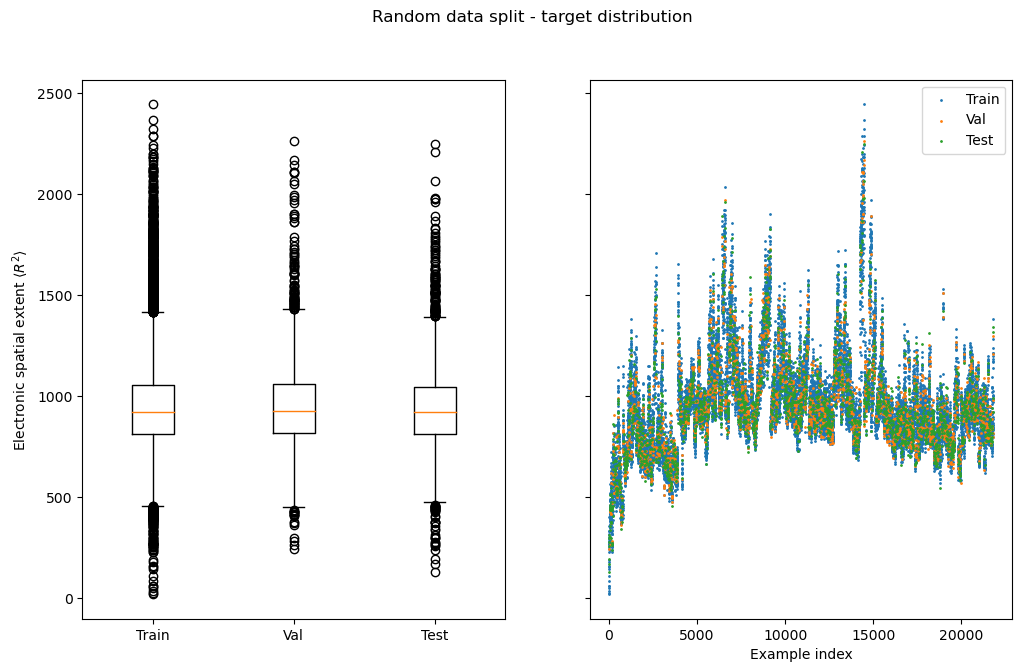

In [9]:
data_module = QM9DataModule()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7), sharey=True)
target = data_module.dataset().data.y.flatten().numpy()
ax1.boxplot(
    [
        target[data_module.train_split],
        target[data_module.val_split],
        target[data_module.test_split],
    ]
)
ax1.set_xticklabels(["Train", "Val", "Test"])
ax1.set_ylabel("Electronic spatial extent $\langle R^2 \\rangle$")

for label, split in {
    "Train": data_module.train_split,
    "Val": data_module.val_split,
    "Test": data_module.test_split,
}.items():
    ax2.scatter(split, target[split], label=label, s=1)

ax2.set_xlabel("Example index")
ax2.legend()
fig.suptitle("Random data split - target distribution")


You should be able to observe that random splits are typically very homogenous, which means generalization might be deceivingly simple.

#### Visualizing atom coordinates and inspecting their relation to electronic spatial extent
Next we will try to visualize the distribution of atoms across euclidean space. In order to achieve this, we will plot *all* atoms, grouped by element (atomic number) with their respective positions and colorize them
* once using their distance to the respective point cloud center and
* once using the target electronic spatial extent of the molecule that is underlying the respective point cloud
  
This choice of colorization should give us some more insight into how electronic spatial extent and atom coordinates are related.

In [10]:
# load all data into one huge batch
aux_loader = data_module.loader(
    np.arange(data_module.num_examples), batch_size=data_module.num_examples
)
batch = [x for x in aux_loader][0]

# compute center (mean coordinate) for all point clouds
# see (https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter)
# for a nice explanation of the scatter operation
center_pos = scatter(batch.pos, batch.batch, 0, reduce="mean")

# compute distance from respective center for all atoms in all point clouds
distance_from_center = (center_pos[batch.batch] - batch.pos).pow(2).sum(1).sqrt()


Text(0.5, 0.98, 'Atom coordinate visualization for all 21800 point clouds in the data')

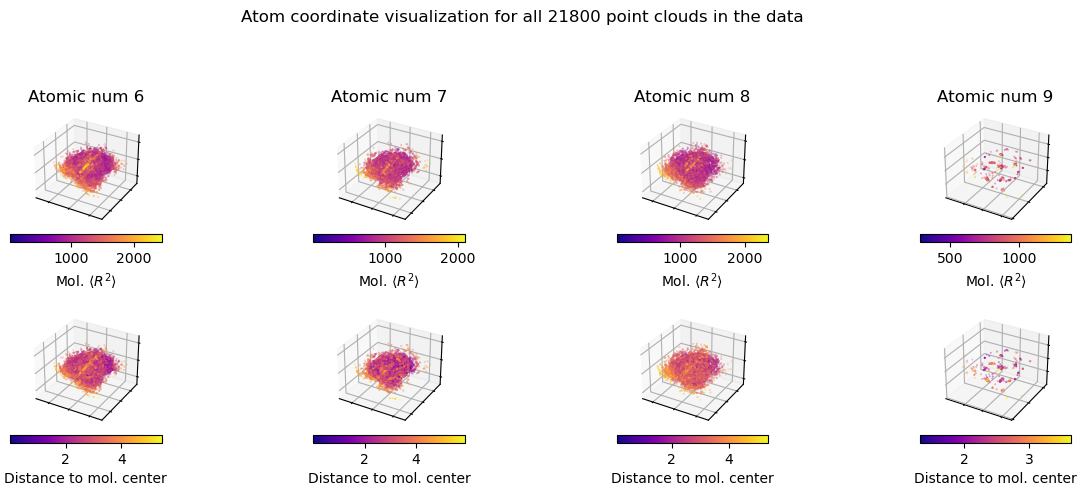

In [11]:
def plot_all_atoms_with_position(
    atomic_num: int, z, pos, color, fig, ax_pos, color_label
) -> mpl.axis.Axis:
    mask = z == atomic_num
    pos = pos[mask, :].T
    color = color[mask]
    return plot_point_cloud_3d(
        fig,
        ax_pos,
        color,
        pos,
        point_size=0.1,
        annotate_points=False,
        remove_axes_ticks=True,
        label_axes=False,
        cbar_label=color_label,
    )


fig = plt.figure(figsize=(15, 10))
for atomic_num in [6, 7, 8, 9]:
    ax = plot_all_atoms_with_position(
        atomic_num,
        batch.z,
        batch.pos,
        batch.y[batch.batch],
        fig,
        440 + (atomic_num - 5),
        "Mol. $\langle R^2 \\rangle$",
    )
    ax.set_title(f"Atomic num {atomic_num}")
    ax = plot_all_atoms_with_position(
        atomic_num,
        batch.z,
        batch.pos,
        distance_from_center,
        fig,
        440 + (atomic_num - 1),
        "Distance to mol. center",
    )

fig.suptitle(
    f"Atom coordinate visualization for all {data_module.num_examples} point clouds in the data"
)


This supports our intuition that electronic spatial extent is positively correlated with the "volume" of a molecule (volumes with large volume tend to contain atoms that are further from the center)

### Model implementation

#### Plain "naive euclidean" GNN
A naive way to incorporate 3D coordinates into a GNN for molecular graphs would be to interpret them as atom-level features.
It is easy to implement a simple baseline model which does exactly this. Our model uses atomic numbers as node features (the $d$ in $Z \in \mathbb{R}^{n \times d}$ is fixed to $1$) and the adjacency induced by covalent bonds for message passing.

In [12]:
class NaiveEuclideanGNN(nn.Module):
    def __init__(
        self,
        hidden_channels: int,
        num_layers: int,
        num_spatial_dims: int,
        gnn_out_channels: Optional[int] = None,
        act: nn.Module = nn.ReLU(),
    ) -> None:
        super().__init__()
        # NOTE nn.Embedding acts like a lookup table.
        # Here we use it to store for each atomic number in [0,100]
        # a learnable, fixed size vector representation
        self.f_initial_embed = nn.Embedding(100, hidden_channels)
        self.f_pos_embed = nn.Linear(num_spatial_dims, hidden_channels)
        self.f_combine = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels), act
        )

        if gnn_out_channels is None:
            gnn_out_channels = hidden_channels

        # meat of the model. Here we use a
        # graph isomorphism network as backbone.
        # takes care of message passing and
        # learning node-level embeddings
        self.gnn = geom_nn.models.GIN(
            in_channels=hidden_channels,
            hidden_channels=hidden_channels,
            out_channels=gnn_out_channels,
            num_layers=num_layers,
            act=act,
        )

        # modules required for aggregating node embeddings
        # into graph embeddings and making graph-level predictions
        self.aggregation = geom_nn.aggr.SumAggregation()
        self.f_predict = nn.Sequential(
            nn.Linear(gnn_out_channels, gnn_out_channels),
            act,
            nn.Linear(gnn_out_channels, 1),
        )

    def encode(self, data: Data) -> Tensor:
        # initial atomic number embedding and embedding od positional information
        atom_embedding = self.f_initial_embed(data.z)
        pos_embedding = self.f_pos_embed(data.pos)

        # treat both as plain node-level features and combine into initial node-level
        # embedddings
        initial_node_embed = self.f_combine(
            torch.cat((atom_embedding, pos_embedding), dim=-1)
        )

        # message passing
        # NOTE in contrast to the EGNN implemented later, this model does use bond information
        # i.e., data.egde_index stems from the bond adjacency matrix
        node_embed = self.gnn(initial_node_embed, data.edge_index)
        return node_embed

    def forward(self, data: Data) -> Tensor:
        node_embed = self.encode(data)
        aggr = self.aggregation(node_embed, data.batch)
        return self.f_predict(aggr)


#### Demo: Plain GNNs are not E(3) invariant
However, this approach is problematic because the corresponding atom embeddings of a regular GNN (from which we would also derive our final predictions) will not be $\text{E}(3)$-invariant. This is easily demonstrated by visualizing the behavior of a plain graph convolutional network (GCN).

In [13]:
# set up 3D rotation along z-axis as example E(3) transform
def rotation_matrix_z(theta: float) -> Tensor:
    return torch.tensor(
        [
            [math.cos(theta), -math.sin(theta), 0],
            [math.sin(theta), math.cos(theta), 0],
            [0, 0, 1],
        ]
    )


*NOTE*: you may need to run the cell below multiple times to find a model initialization for which non-invariance can easily be observed.

/var/folders/8r/pydj0px5315ckmngntlp2m3c0000gn/T/ipykernel_61111/2662636593.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


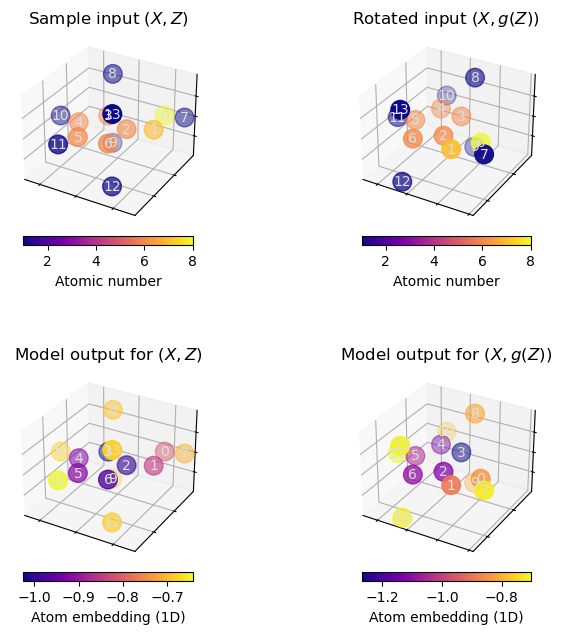

In [28]:
# some datapoint from qm9
sample_data = dataset[800].clone()

# apply an E(3) transformation
rotated_sample_data = sample_data.clone()
rotated_sample_data.pos = rotated_sample_data.pos @ rotation_matrix_z(45)

# initialize a model with 2 hidden layers, 32 hidden channels, 
# that outputs 1-dimensional node embeddings
model = NaiveEuclideanGNN(
    hidden_channels=32,
    num_layers=2,
    num_spatial_dims=3,
    gnn_out_channels=1,
)

# make a plot that demonstrates non-equivariance
# fig, axes = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)
fig = plt.figure(figsize=(8,8))

ax1 = plot_model_input(sample_data, fig, 221)
ax1.set_title("Sample input $(X, Z)$")

ax2 = plot_model_input(rotated_sample_data, fig, 222)
ax2.set_title("Rotated input $(X, g(Z))$")

ax3 = plot_model_embedding(sample_data, model.encode, fig, 223)
ax3.set_title("Model output for $(X, Z)$")

ax4 = plot_model_embedding(rotated_sample_data, model.encode, fig, 224)
ax4.set_title("Model output for $(X, g(Z))$")
fig.tight_layout()

When executing the above cells a few times, we can observe that rotating the molecule may *significantly* alter the atom embeddings obtained from the GCN model.

#### EGNN model

We now implement an $\text{E}(n)$-invariant GNN based on the principles outlined in the [theory section](...).

In [15]:
class EquivariantMPLayer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        act: nn.Module,
    ) -> None:
        super().__init__()
        self.act = act
        self.residual_proj = nn.Linear(in_channels, hidden_channels, bias=False)

        # message input: source node, target node, distance
        message_input_size = 2 * in_channels + 1
        # equation (3) "phi_l"
        self.message_mlp = nn.Sequential(
            nn.Linear(message_input_size, hidden_channels),
            act,
        )
        # equation (4) "psi_l"
        self.node_update_mlp = nn.Sequential(
            nn.Linear(in_channels + hidden_channels, hidden_channels),
            act,
        )

    def node_message_function(
        self,
        source_node_embed: Tensor,  # j
        target_node_embed: Tensor,  # i
        node_dist: Tensor,
    ) -> Tensor:
        # implements equation (3)
        inp = torch.cat((source_node_embed, target_node_embed, node_dist), dim=-1)
        return self.message_mlp(inp)

    def compute_distances(self, node_pos: Tensor, edge_index: LongTensor) -> Tensor:
        row, col = edge_index
        xi, xj = node_pos[row], node_pos[col]
        # relative squared distance
        # implements equation (2) ||X_i - X_j||^2
        rsdist = (xi - xj).pow(2).sum(1, keepdim=True)
        return rsdist

    def forward(
        self,
        node_embed: Tensor,
        node_pos: Tensor,
        edge_index: Tensor,
    ) -> Tensor:
        row, col = edge_index
        dist = self.compute_distances(node_pos, edge_index)

        # compute messages "m_ij" from  equation (3)
        node_messages = self.node_message_function(
            node_embed[row], node_embed[col], dist
        )

        # message sum aggregation in equation (4)
        aggr_node_messages = scatter(node_messages, col, dim=0, reduce="sum")

        # compute new node embeddings "h_i^{l+1}"
        # (implements rest of equation (4))
        new_node_embed = self.residual_proj(node_embed) + self.node_update_mlp(
            torch.cat((node_embed, aggr_node_messages), dim=-1)
        )

        return new_node_embed


class EquivariantGNN(nn.Module):
    def __init__(
        self,
        hidden_channels: int,
        output_channels: Optional[int] = None,
        target_size: int = 1,
        num_mp_layers: int = 2,
    ) -> None:
        super().__init__()
        if output_channels is None:
            output_channels = hidden_channels

        # non-lienar activation func.
        # usually configurable, here we just use relu for simplicity
        self.act = nn.ReLU()

        # equation (1) "psi_0"
        self.f_initial_embed = nn.Embedding(100, hidden_channels)
        
        # create stack of MP layers
        self.message_passing_layers = nn.ModuleList()
        channels = [hidden_channels] * (num_mp_layers) + [output_channels]
        for d_in, d_out in zip(channels[:-1], channels[1:]):
            layer = EquivariantMPLayer(
                d_in, d_out, self.act
            )
            self.message_passing_layers.append(layer)

        # modules required for readout of a graph-level
        # representation and graph-level property prediction
        self.aggregation = SumAggregation()
        self.f_predict = nn.Sequential(
            nn.Linear(output_channels, output_channels),
            self.act,
            nn.Linear(hidden_channels, target_size),
        )

    def encode(self, data: Data) -> Tensor:
        # theory, equation (1)
        node_embed = self.f_initial_embed(data.z)
        # message passing
        # theory, equation (3-4)
        for mp_layer in self.message_passing_layers:
            # NOTE we here use the complete edge index defined by the transform earlier on
            node_embed = mp_layer(node_embed, data.pos, data.complete_edge_index)
        return node_embed

    def predict(self, node_embed, batch) -> Tensor:
        aggr = self.aggregation(node_embed, batch)
        return self.f_predict(aggr)

    def forward(self, data: Data) -> Tensor:
        node_embed = self.encode(data)
        pred = self.predict(node_embed, data.batch)
        return pred


#### Demo: Our EGNN is E(3)-invariant
We can collect evidence that this model is indeed $\text{E}(n)$-invariant by repeating the experiment we conducted earlier.

In [16]:
model = EquivariantGNN(
    hidden_channels=32,
    output_channels=1,
    num_mp_layers=2
)

/var/folders/8r/pydj0px5315ckmngntlp2m3c0000gn/T/ipykernel_61111/2959515678.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


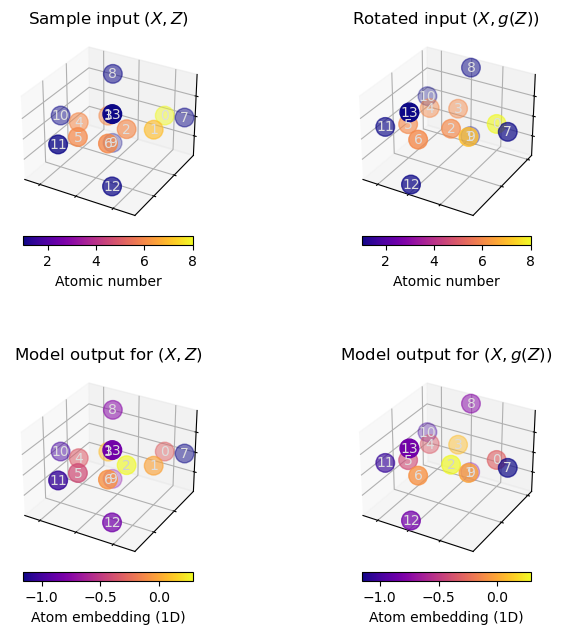

In [17]:
# some datapoint from qm9
sample_data = dataset[800].clone()

# apply E(3) transformation
rotated_sample_data = sample_data.clone()
rotated_sample_data.pos = rotated_sample_data.pos @ rotation_matrix_z(120)

fig = plt.figure(figsize=(8,8))

ax1 = plot_model_input(sample_data, fig, 221)
ax1.set_title("Sample input $(X, Z)$")

ax2 = plot_model_input(rotated_sample_data, fig, 222)
ax2.set_title("Rotated input $(X, g(Z))$")

ax3 = plot_model_embedding(sample_data, model.encode, fig, 223)
ax3.set_title("Model output for $(X, Z)$")

ax4 = plot_model_embedding(rotated_sample_data, model.encode, fig, 224)
ax4.set_title("Model output for $(X, g(Z))$")
fig.tight_layout()

You can execute the above cells as often as you like, with whatever you input you choose, the atom embeddings will always be unaffected by the rotation applied to the model input.

### Training and evaluation
Now that we have set up our data and implemented two different models for point clouds, we can start implementing a training and evaluation pipeline.

We will follow the ubiquitous ML principle of also monitoring a validation loss in addition to the training loss. The validation loss acts as an estimate for how well the model generalizes and can be used for selecting a final model to be tested.

In [18]:
# we will be using mean absolute error
# as a metric for validation and testing
def total_absolute_error(pred: Tensor, target: Tensor, batch_dim: int = 0) -> Tensor:
    """Total absolute error, i.e. sums over batch dimension.

    Parameters
    ----------
    pred : Tensor
        batch of model predictions
    target : Tensor
        batch of ground truth / target values
    batch_dim : int, optional
        dimension that indexes batch elements, by default 0

    Returns
    -------
    Tensor
        total absolute error
    """
    return (pred - target).abs().sum(batch_dim)


In [19]:
def run_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: Callable[[Tensor, Tensor], Tensor],
    pbar: Optional[Any] = None,
    optim: Optional[torch.optim.Optimizer] = None,
):
    """
    Run a single epoch
    """
    def step(
        data_batch: Data,
    ) -> Tuple[Optional[float], float]:
        pred = model.forward(data_batch)
        target = data_batch.y
        loss = criterion(pred, target)
        if optim is not None:
            optim.zero_grad()
            loss.backward()
            optim.step()
        return loss.detach().item(), total_absolute_error(
            pred.detach(), target.detach()
        )

    if optim is not None:
        model.train()
        model.requires_grad_(True)
    else:
        model.eval()
        model.requires_grad_(False)

    total_loss = 0
    total_mae = 0
    for data in loader:
        loss, mae = step(data)
        total_loss += loss * data.num_graphs
        total_mae += mae
        if pbar is not None:
            pbar.update(1)

    return total_loss / len(loader.dataset), total_mae / len(loader.dataset)


def train_model(
    data_module: QM9DataModule,
    model: nn.Module,
    num_epochs: int = 30,
    lr: float = 3e-4,
    batch_size: int = 32,
    weight_decay: float = 1e-8,
    best_model_path: Path = DATA.joinpath("trained_model.pth"),
) -> Dict[str, Any]:
    """Takes data and model as input and runs training, collecting additional validation metrics
    while doing so.

    Parameters
    ----------
    data_module : QM9DataModule
        a data module as defined earlier
    model : nn.Module
        a gnn model
    num_epochs : int, optional
        number of epochs to train for, by default 30
    lr : float, optional
        "learning rate": optimizer SGD step size, by default 3e-4
    batch_size : int, optional
        number of examples used for one training step, by default 32
    weight_decay : float, optional
        L2 regularization parameter, by default 1e-8
    best_model_path : Path, optional
        path where the model weights with lowest val. error should be stored
        , by default DATA.joinpath("trained_model.pth")

    Returns
    -------
    Dict[str, Any]
        a training result, ie statistics and info about the model
    """
    # create data loaders
    train_loader = data_module.train_loader(batch_size=batch_size)
    val_loader = data_module.val_loader(batch_size=batch_size)

    # setup optimizer and loss
    optim = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-8)
    loss_fn = nn.MSELoss()

    # keep track of the epoch with best validation mae
    # st we can save the "best" model weights
    best_val_mae = float("inf")

    # statistics that will be plotted later on
    # and model info
    result = {
        "model": model,
        "path_to_best_model": best_model_path,
        "train_loss": np.full(num_epochs, float("nan")),
        "val_loss": np.full(num_epochs, float("nan")),
        "train_mae": np.full(num_epochs, float("nan")),
        "val_mae": np.full(num_epochs, float("nan")),
    }

    # auxiliary functions for updating and reporting
    # training progress statistics
    def update_statistics(i_epoch: int, **kwargs: float):
        for key, value in kwargs.items():
            result[key][i_epoch] = value

    def desc(i_epoch: int) -> str:
        return " | ".join(
            [f"Epoch {i_epoch + 1:3d} / {num_epochs}"]
            + [
                f"{key}: {value[i_epoch]:12.4f}"
                for key, value in result.items()
                if isinstance(value, np.ndarray)
            ]
        )

    # main training loop
    for i_epoch in range(0, num_epochs):
        progress_bar = tqdm(total=len(train_loader) + len(val_loader))
        try:
            # tqdm for reporting progress
            progress_bar.set_description(desc(i_epoch))

            train_loss, train_mae = run_epoch(
                model, train_loader, loss_fn, progress_bar, optim
            )
            val_loss, val_mae = run_epoch(model, val_loader, loss_fn, progress_bar)

            update_statistics(
                i_epoch,
                train_loss=train_loss,
                val_loss=val_loss,
                train_mae=train_mae,
                val_mae=val_mae,
            )

            progress_bar.set_description(desc(i_epoch))

            if val_mae < best_val_mae:
                best_val_mae = val_mae
                torch.save(model.state_dict(), best_model_path)
        finally:
            progress_bar.close()

    return result


In [20]:
@torch.no_grad()
def test_model(
    model: nn.Module,
    data_module: QM9DataModule
) -> Tuple[float, Tensor, Tensor]:
    """
    Test a model.
    
    Parameters
    ----------
    model : nn.Module
        a trained model
    data_module : QM9DataModule
        a data module as defined earlier
        from which we'll get the test data

    Returns
    -------
    _Tuple[float, Tensor, Tensor]
        Test MAE, and model predictions & targets for further processing
    """
    test_mae = 0
    preds, targets = [], []
    loader = data_module.test_loader()
    for data in loader:
        pred = model(data)
        target = data.y
        preds.append(pred)
        targets.append(target)
        test_mae += total_absolute_error(pred, target).item()

    test_mae = test_mae / len(data_module.test_split)

    return test_mae, torch.cat(preds, dim=0), torch.cat(targets, dim=0)

#### Training the EGNN

In [21]:
model = EquivariantGNN(hidden_channels=64, num_mp_layers=2)

egnn_train_result = train_model(
    data_module,
    model,
    num_epochs=25,
    lr=2e-4,
    batch_size=32,
    weight_decay=1e-8,
    best_model_path=DATA.joinpath("trained_egnn.pth")
)


Epoch   1 / 25 | train_loss:   83931.3815 | val_loss:    7531.1213 | train_mae:     170.7073 | val_mae:      67.6926: 100%|██████████| 614/614 [00:17<00:00, 35.36it/s]
Epoch   2 / 25 | train_loss:    3638.1721 | val_loss:    1577.4672 | train_mae:      42.1210 | val_mae:      26.6419: 100%|██████████| 614/614 [00:14<00:00, 41.37it/s]
Epoch   3 / 25 | train_loss:    1226.8999 | val_loss:     683.1587 | train_mae:      24.4343 | val_mae:      18.1488: 100%|██████████| 614/614 [00:15<00:00, 40.14it/s]
Epoch   4 / 25 | train_loss:     648.2368 | val_loss:     374.6164 | train_mae:      17.6028 | val_mae:      12.7572: 100%|██████████| 614/614 [00:15<00:00, 39.82it/s]
Epoch   5 / 25 | train_loss:     433.2215 | val_loss:     267.7150 | train_mae:      14.1458 | val_mae:      10.4497: 100%|██████████| 614/614 [00:15<00:00, 39.98it/s]
Epoch   6 / 25 | train_loss:     325.6504 | val_loss:     185.3200 | train_mae:      12.3502 | val_mae:       8.3608: 100%|██████████| 614/614 [00:14<00:00, 41.

#### Training the plain GNN

In [22]:
gcn_baseline = NaiveEuclideanGNN(64, 4, 3)

gcn_train_result = train_model(
    data_module,
    gcn_baseline,
    num_epochs=100,
    lr=3e-4,
    batch_size=32,
    best_model_path=DATA.joinpath("trained_gnn.pth")
)

Epoch   1 / 100 | train_loss:  126637.9363 | val_loss:   50486.3232 | train_mae:     252.0302 | val_mae:     176.1353: 100%|██████████| 614/614 [00:07<00:00, 76.99it/s] 
Epoch   2 / 100 | train_loss:   45832.6730 | val_loss:   37412.5404 | train_mae:     159.3377 | val_mae:     149.5668: 100%|██████████| 614/614 [00:05<00:00, 115.32it/s]
Epoch   3 / 100 | train_loss:   32619.6674 | val_loss:   28356.2117 | train_mae:     136.6531 | val_mae:     127.7487: 100%|██████████| 614/614 [00:05<00:00, 112.50it/s]
Epoch   4 / 100 | train_loss:   19401.4769 | val_loss:   15797.6817 | train_mae:     104.8251 | val_mae:      93.4712: 100%|██████████| 614/614 [00:05<00:00, 117.51it/s]
Epoch   5 / 100 | train_loss:   12002.6226 | val_loss:   11028.4939 | train_mae:      81.9481 | val_mae:      77.2107: 100%|██████████| 614/614 [00:05<00:00, 114.58it/s]
Epoch   6 / 100 | train_loss:    8944.8481 | val_loss:    7798.4254 | train_mae:      70.4208 | val_mae:      63.6574: 100%|██████████| 614/614 [00:05

#### Comparative evaluation

Let us now compare the trained EGNN and GNN baseline model. First note that in terms of capacity (measured by number of trainable parameters) the models are very similar. But be aware that the comparison is still not completely fair, because
* the EGNN is a *message-passing* neural network while the baseline GNN is a type of *graph convolutional* neural network
* the EGNN is run on complete graphs, whereas the baseline GNN uses the bond adjacency info, which could also be a disadvantage

In [23]:
gcn_num_params = sum(p.numel() for p in gcn_train_result["model"].parameters())
egnn_num_params = sum(p.numel() for p in egnn_train_result["model"].parameters())

for key, value in {"GCN": gcn_num_params, "EGNN": egnn_num_params}.items():
    print(f"{key} has {value} parameters")

GCN has 52417 parameters
EGNN has 51969 parameters


Plotting the loss and validation MAE for each epoch, we can observe that the EGNN training progresses *much* faster and yields *much* better results,
even though it is trained for a smaller number of epochs (note that loss and MAE are in log-scale).

Surprisingly the validation loss/MAE for the EGNN is sometimes *lower* than the train loss/MAE. This might be explained by the fact that the data split is *very* homogenous and the validation data contains less outliers than the train data (see boxplots from the section on distribution of regression target across splits).

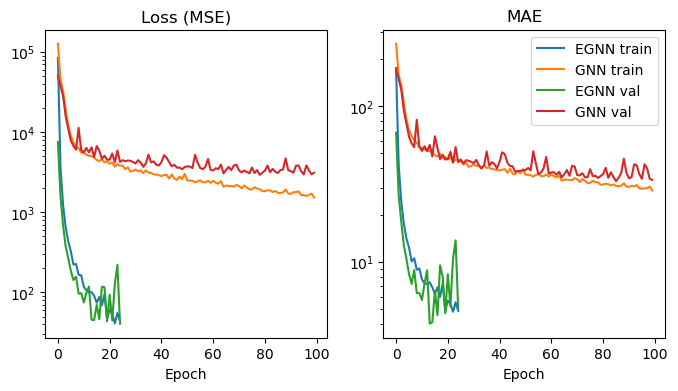

In [24]:
fig, (loss_ax, mae_ax) = plt.subplots(1, 2, figsize=(8,4))

loss_ax.set_title("Loss (MSE)")
mae_ax.set_title("MAE")
loss_ax.set_xlabel("Epoch")
mae_ax.set_xlabel("Epoch")

for metric in ["train_loss", "val_loss", "train_mae", "val_mae"]:
    split = metric.split('_')[0]
    ax = loss_ax if "loss" in metric else mae_ax
    
    ax.plot(egnn_train_result[metric], label=f"EGNN {split}")
    ax.plot(gcn_train_result[metric], label=f"GNN {split}")

mae_ax.legend()
mae_ax.set_yscale("log")
loss_ax.set_yscale("log")


This improvement in performance can also be obsverved on the held out test data. For testing we select the best model as the model that had the lowest valdiation MAE each.

In [25]:
gcn_model = gcn_train_result["model"]
gcn_model.load_state_dict(torch.load(gcn_train_result["path_to_best_model"]))
gcn_test_mae, gcn_preds, gcn_targets = test_model(gcn_model, data_module)

egnn_model = egnn_train_result["model"]
egnn_model.load_state_dict(torch.load(egnn_train_result["path_to_best_model"]))
egnn_test_mae, egnn_preds, egnn_targets = test_model(egnn_model, data_module)

print(f"EGNN test MAE: {egnn_test_mae}")
print(f"GNN test MAE: {gcn_test_mae}")

EGNN test MAE: 4.121410922829164
GNN test MAE: 34.19072292222889


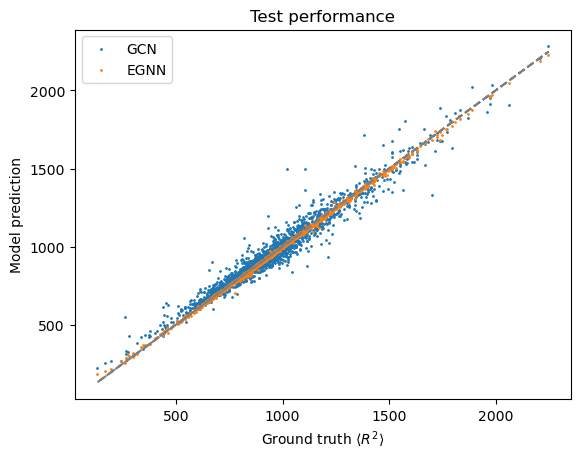

In [26]:
fig, ax = plt.subplots()
ax.plot(gcn_targets, gcn_targets, "--", color="grey")
ax.scatter(gcn_targets, gcn_preds, s=1, label="GCN")
ax.scatter(egnn_targets, egnn_preds, s=1, label="EGNN")
ax.set_ylabel("Model prediction")
ax.set_xlabel("Ground truth $\langle R^2 \\rangle$")
ax.set_title("Test performance")
ax.legend()

These findings support out initial hypothesis that $\text{E}(3)$-invariant models lead to faster learning and improved generalization performance.

## Discussion

### Summary
You have now seen, theoretically and practically, why we need (S)E(3) equi-/invariant models to work with point cloud representations of molecules and how to implement, train and evaluate them. The dataset used here is not directly relevant to CADD, but the practical importance of (S)E(3) equi-/invariance definitely carries over to more relevant applications such as protein ligand docking. Recent work on molecular representation learning also suggests that 3D point clouds are favored for a broad range of property prediction tasks more relevant to CADD such as toxicity prediction (TODO CITE 3D Mol Net paper).

### Caveats of our approach
At this point we should also go over some final caveats with the EGNN presented here and our approach in general:

1. For performance reasons it is usually better to use dense rather than sparse (used by our implementation) adjacency/edge tensors for message passing if working with complete graphs.
2. Our EGNN model is E(3)-invariant. Note that some molecular properties are *sensitive* to reflection, In such settings, SE(3)-invariance should be the preferred model property (see TODO CITE for more information).
3. Random data splits are considered bad practice since they make generalization very easy (see [this paper](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0391-2) which analyzes and discusses this issue in-depth for QM9)


## Quiz

1. In addition to 3D coordinates, what is strictly required for inference of covalent bonds between atoms?
2. What is the difference between equivariance and invariance?
3. True or false? SE(3) contains transformations which are not included in E(3).
4. True or false? The atom embeddings $h$ computed by iterating the following message passing scheme for a fixed number of steps are E(3)-invariant
\begin{align*}
    m_{ij}^{l} &= \phi_{l}(h_i^l, h_j^l, X_i - X_j)  \\
    h_{i}^{l+1} &= \psi_l(h_{i}^l, \sum_{j \neq i} m_{ij}^l)
\end{align*}

<div class="alert alert-block alert-info">

<b>Useful checks at the end</b>: 
    
<ul>
<li>Clear output and rerun your complete notebook. Does it finish without errors?</li>
<li>Check if your talktorial's runtime is as excepted. If not, try to find out which step(s) take unexpectedly long.</li>
<li>Flag code cells with <code># NBVAL_CHECK_OUTPUT</code> that have deterministic output and should be tested within our Continuous Integration (CI) framework.</li>
</ul>

</div>